In [1]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [2]:
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]

path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

# Se abre el archivo histórico y el del año en curso.
ds = xr.open_mfdataset( [ path_nc + x for x in names[0:2] ],
    combine = "nested", concat_dim = "time", parallel = True )

# Convertimos el promedio a dataframe.
df = ds.mean( ["latitude", "longitude"] ).to_dataframe()

# Quitamos los 29 de febrero.
ds = ( ds.sel( time = ~( (ds.time.dt.month == 2) & (ds.time.dt.day == 29) ) ) )

# Cantidad de días a promediar.
d = 20

# Media móvil de precipitación centrada a 15 días.
ds = ( ds.rolling(time = d, center = True).mean() )

ds

<xarray.Dataset>
Dimensions:    (time: 14812, longitude: 31, latitude: 35)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-07-31
  * longitude  (longitude) float32 -99.73 -99.68 -99.63 ... -98.33 -98.28 -98.23
  * latitude   (latitude) float32 19.07 19.12 19.17 19.22 ... 20.67 20.72 20.77
Data variables:
    precip     (time, latitude, longitude) float64 dask.array<chunksize=(14610, 35, 31), meta=np.ndarray>
Attributes: (12/17)
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Mon Sep 13 20:14:46 2021: cdo mergetime cuenca_valle_m...
    institution:       Climate Hazards Group.  University of California at Sa...
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    version:           Version 2.0
    ...                ...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

In [3]:
# Precipitación total y estacional.

df = ds.mean( ["latitude", "longitude"] ).to_dataframe()
df = df.resample("M").sum()
df = df.groupby(df.index.month).mean()
tot = df.sum().values[0]

# Precipitación total.
print( f"Total: {tot}" )
# Parciales.
print("Junio, julio, agosto")
print( df[ df.index.isin( [6, 7, 8] ) ].sum().values[0] * 100 / tot )
print("Junio, julio, agosto, septiembre")
print( df[ df.index.isin( [6, 7, 8, 9] ) ].sum().values[0] * 100 / tot )
print("Noviembre, diciembre, enero, febrero")
print( df[ df.index.isin( [11, 12, 1, 2] ) ].sum().values[0] * 100 / tot )

754.6435240880605
51.801664212675504
69.70940961674802
7.438505981567691


In [4]:
# Se carga el contorno de México.
gdf = gpd.read_file(path_shp + names[2])

# Se obtiene el contorno de los países.
gdf["boundary"] = gdf.boundary

# Se establece el datum de los datos.
ds = ds.rio.write_crs(gdf.crs)

# Se hace la máscara de México.
clip = ds.rio.clip(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
    gdf.crs, drop=False, invert=False).drop("spatial_ref")

In [5]:
pre_xr = clip.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

# Convertimos a DataFrame.
df_mean = pre_xr_mean.mean( ["longitude", "latitude"]).to_dataframe()
df_mean.columns = ["Cuenca"]

# Cambiamos de dayofyear a fecha.
df_mean.index = pd.date_range( "1995-01-01", "1995-12-31", freq = "1D" )

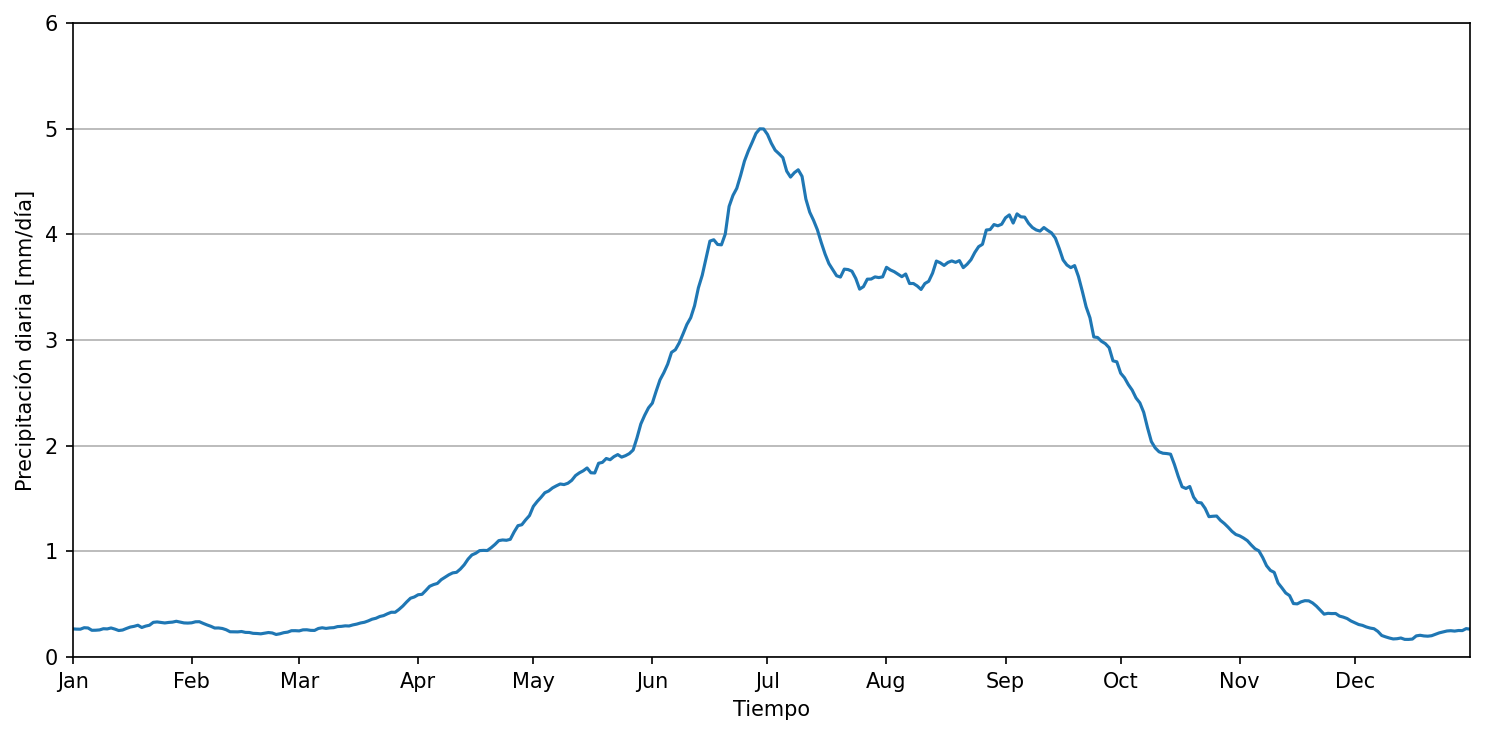

In [6]:
# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_mean)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm/día]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"), pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "pre_mean_cuenca_CHIRPS.png", bbox_inches = "tight" )

Onset     : 03 June
Withdrawal: 15 October


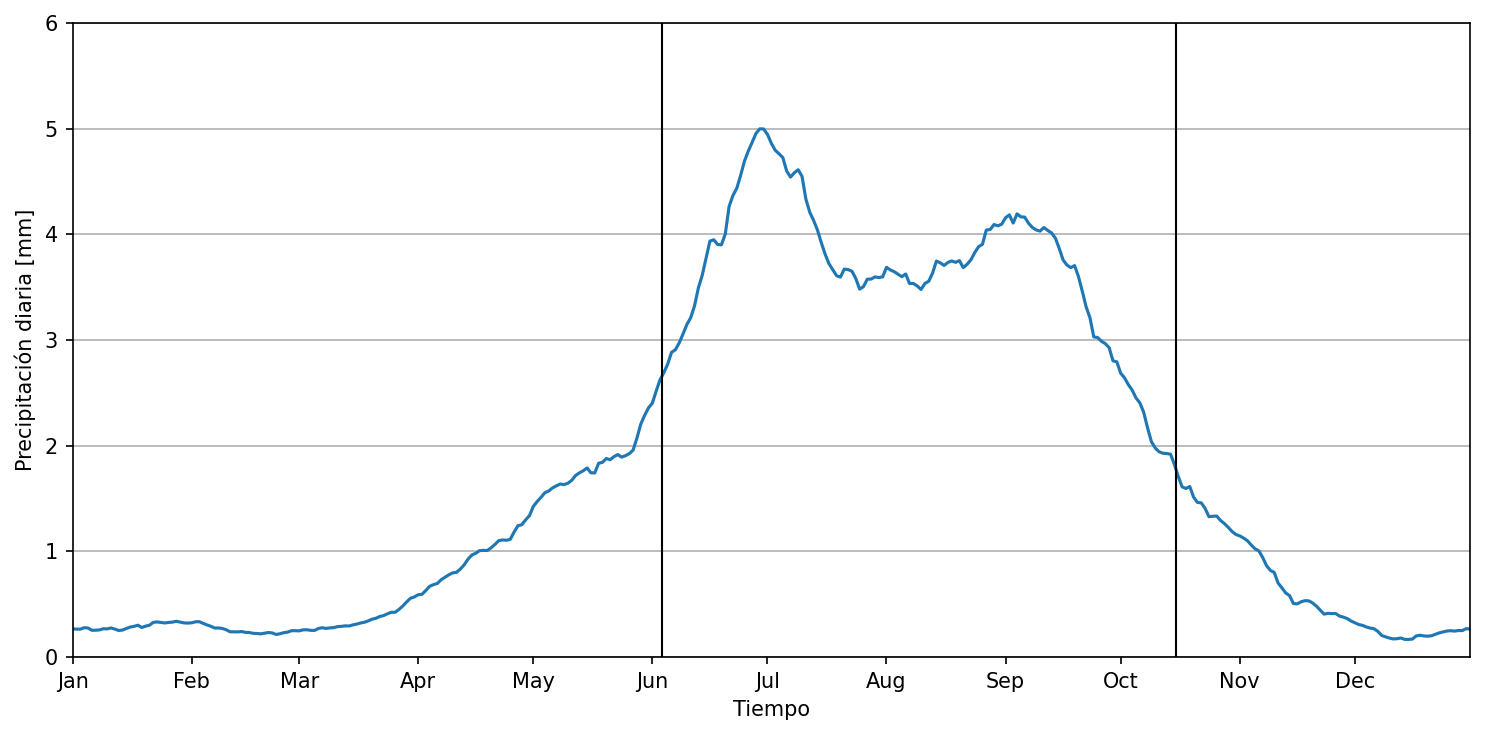

In [7]:
# Cargamos el archivo y ajustamos formatos.
date = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año" )
date.index = pd.RangeIndex(date.index[0], date.index[-1] + 1, name = "Año" )
date.iloc[:, 0] = pd.to_datetime( date.iloc[:, 0] )
date.iloc[:, 1] = pd.to_datetime( date.iloc[:, 1] )

# Convertimos a día juliano.
date.iloc[:, 0] = date.iloc[:, 0].apply(lambda x: x.dayofyear)
date.iloc[:, 1] = date.iloc[:, 1].apply(lambda x: x.dayofyear)
# Ajustamos los años bisiestos.
date.iloc[date.index % 4 == 0, 0:2] = date.iloc[date.index % 4 == 0, 0:2] - 1

# Reconvertimos a fecha.
date.iloc[:, 0] = ( pd.to_datetime("1995-01-01")
    + pd.to_timedelta(date.iloc[:, 0], "D") )
date.iloc[:, 1] = ( pd.to_datetime("1995-01-01")
    + pd.to_timedelta(date.iloc[:, 1], "D") )

# Fechas.
onset = date.iloc[:, 0].mean()
withdrawal = date.iloc[:, 1].mean()

print( f"Onset     : {onset.day:02d}" + f" {onset.month_name()}" )
print( f"Withdrawal: {withdrawal.day:02d}" + f" {withdrawal.month_name()}" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Curva suavizada.
ax.plot(df_mean)

# Onset y withdrawal.
ax.plot( (onset, onset), (0, 6), color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal), (0, 6), color = "k", linewidth = 1 )

ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"),
    pd.to_datetime("1995-12-31") )
ax.set_title("")
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind_cuenca_CHIRPS.png", bbox_inches = "tight")
